This is Page 1

# Firm Valuation with Exit


The productivity of a firm $(Z_t)$ follows $Q$-Markov.  

Profits are given by $\pi_t = \pi(Z_t)$.

At the start of each period, the firm chooses either
- to remain in operation and receive current profit $\pi_t$, or
- to exit and receive scrap value $s > 0$ for sale of physical assets.

Discouting is at fixed rate $\beta \in (0, 1)$.

The corresponding Bellman equation is

$$(T v)(z) = \max \left\{s, \pi(z) + \beta \sum_{z'} v(z') Q(z, z') \right\}.$$


In [1]:
# This is Page 2

from quantecon.markov import tauchen
from quantecon import compute_fixed_point

import numpy as np
from collections import namedtuple
from numba import njit

import matplotlib.pyplot as plt

In [2]:
# This is Page 3

# NamedTuple Model
Model = namedtuple("Model", ("n", "z_vals", "Q", "β", "s"))


def create_exit_model(
        n=200,                  # productivity grid size
        ρ=0.95, μ=0.1, ν=0.1,   # persistence, mean and volatility
        β=0.98, s=100.0         # discount factor and scrap value
    ):
    """
    Creates an instance of the firm exit model.
    """
    
    mc = tauchen(n, ρ, ν, mu=μ)
    z_vals, Q = mc.state_values, mc.P
    
    return Model(n=n, z_vals=z_vals, Q=Q, β=β, s=s)

In [3]:
# This is Page 4

@njit
def T(v, model):
    
    """
    The Bellman operator Tv = max{s, π + β Q v}.
    """
    
    n, z_vals, Q, β, s = model
    h = z_vals + β * Q @ v
    
    return np.maximum(s, h)


@njit
def get_greedy(v, model):
    """
    Get a v-greedy policy.
    """
    
    n, z_vals, Q, β, s = model
    σ = s >= z_vals + β * Q @ v
    
    return σ


def vfi(model):
    """
    Solve by VFI.
    """
    
    v_init = np.zeros(model.z_vals.shape)
    v_star = compute_fixed_point(lambda v: T(v, model), v_init, error_tol=1e-6,
                                 max_iter=1000, print_skip=25)
    σ_star = get_greedy(v_star, model)
    
    return v_star, σ_star

Iteration    Distance       Elapsed (seconds)
---------------------------------------------
25           1.838e-01      5.636e-01         
50           4.985e-02      5.662e-01         
75           1.722e-02      5.703e-01         
100          6.492e-03      5.728e-01         
125          2.524e-03      5.749e-01         
150          9.964e-04      5.772e-01         
175          3.953e-04      5.794e-01         
200          1.569e-04      5.824e-01         
225          6.228e-05      5.844e-01         
250          2.472e-05      5.863e-01         
275          9.814e-06      5.879e-01         
300          3.896e-06      5.903e-01         
325          1.546e-06      5.917e-01         
337          9.925e-07      5.924e-01         
Converged in 337 steps


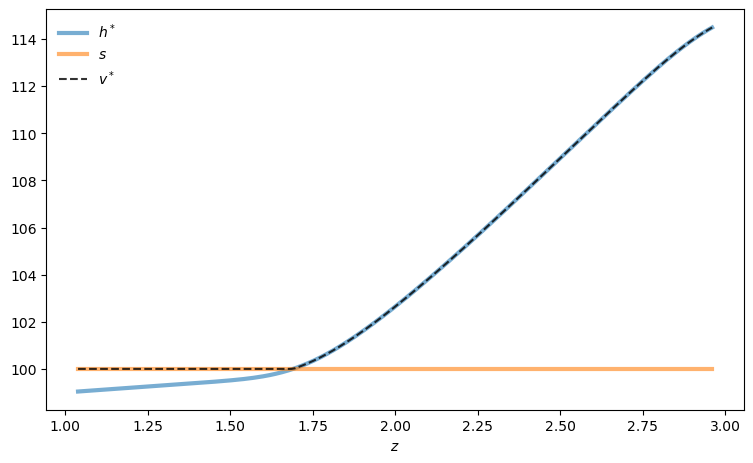

In [4]:
# This is Page 5

# Plots
fig, ax = plt.subplots(figsize=(9, 5.2))

model = create_exit_model()
n, z_vals, Q, β, s = model

v_star, σ_star = vfi(model)
h = z_vals + β * Q @ v_star

ax.plot(z_vals, h, "-", linewidth=3, alpha=0.6, label=r"$h^*$")
ax.plot(z_vals, s * np.ones(n), "-", linewidth=3, alpha=0.6, label=r"$s$")
ax.plot(z_vals, v_star, "k--", linewidth=1.5, alpha=0.8, label=r"$v^*$")

ax.legend(frameon=False)
ax.set_xlabel(r"$z$")

plt.show()

This is Page 6

## Exit Versus No-Exit

We define $w$ by

$$ w(z) = \mathbb{E}_z \sum_{t \geq 0} \beta^t \pi_t.$$

$w(z)$ is the value of the firm given $Z_0 = z$ when the firm never exits so that $w$ evaluates the firm according to expected present value of the profit stream.

We claim that $w \leq v^*$. Choosing never to exist is a feasible policy $\sigma \equiv 0$. Since $v^*$ involves maximization of firm value over the set of all feasible policies, it must be at least as large as the value of never exiting.

In [5]:
# This is Page 7

@njit
def no_exit_value(model):
    """
    Compute value of firm without exit option
    """
    
    n, z_vals, Q, β, s = model
    I = np.identity(n)
    
    return np.linalg.solve((I - β * Q), z_vals)

Iteration    Distance       Elapsed (seconds)
---------------------------------------------
25           1.838e-01      4.074e-03         
50           4.985e-02      6.912e-03         
75           1.722e-02      9.997e-03         
100          6.492e-03      1.309e-02         
125          2.524e-03      1.567e-02         
150          9.964e-04      1.875e-02         
175          3.953e-04      2.179e-02         
200          1.569e-04      2.449e-02         
225          6.228e-05      2.657e-02         
250          2.472e-05      2.842e-02         
275          9.814e-06      3.135e-02         
300          3.896e-06      3.389e-02         
325          1.546e-06      3.606e-02         
337          9.925e-07      3.729e-02         
Converged in 337 steps


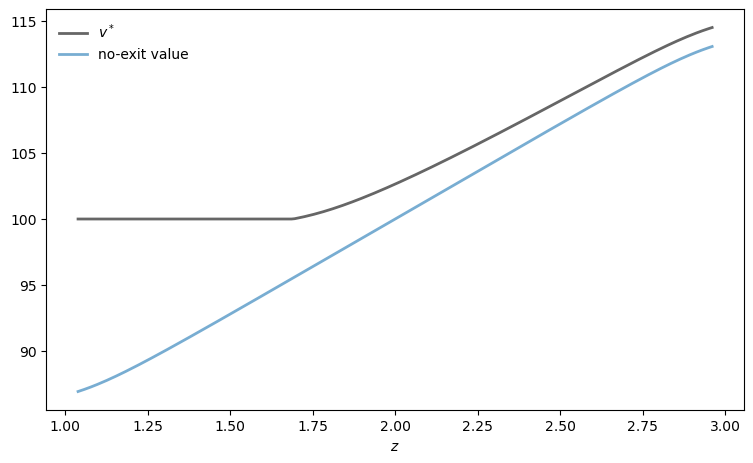

In [6]:
# This is Page 8

fig, ax = plt.subplots(figsize=(9, 5.2))

model = create_exit_model()
n, z_vals, Q, β, s = model

v_star, σ_star = vfi(model)
w = no_exit_value(model)

ax.plot(z_vals, v_star, "k-", linewidth=2, alpha=0.6, label="$v^*$")
ax.plot(z_vals, w, linewidth=2, alpha=0.6, label="no-exit value")

ax.legend(frameon=False)
ax.set_xlabel(r"$z$")

plt.show()

This is Page 9

# Extension to D-robust Expectation

The firm does not know the stochastic kernel $Q$ chosen by nature. But it knows $Q$ belongs to a set $\mathbb{Q}$.

The firm evaluates the value given an action and a state by D-robust expectation with respect to $\bar Q$.

The corresponding Bellman equation is

$$(T v)(z) = \max \left\{s, \pi(z) + \beta \inf_{P \in \mathbb{Q}} \left[\sum_{z'} v(z') P(z, z')  + D_{KL}(P(z) || \bar Q(z)) \right] \right\},$$

where

$$ D_{KL}(P(z) || \bar Q(z)) = \sum_{z'} P(z, z') \log \frac{P(z, z')}{\bar Q(z, z')}.$$

This is Page 10

First, we solve the minimization pointvise in state $z$:

$$\mathcal{L}(P, \lambda) = \sum_{z'} P(z, z') v(z') + \sum_{z'} P(z, z') \log \left( \frac{P(z, z')}{\bar Q(z, z')} \right) - \lambda \left( \sum_{z'} P(z, z') - 1 \right)$$

$$\frac{\partial \mathcal{L}}{\partial P(z, z')} = v(z') + \log \left( \frac{P(z, z')}{\bar Q(z, z')} \right) + 1 - \lambda = 0$$

$$\log \left( \frac{P(z, z')}{\bar Q(z, z')} \right) = \lambda - v(z') - 1$$

$$P(z, z') = \bar Q(z, z') e^{\lambda - v(z') - 1}$$



Use the constraint $\sum_{z'} P(z, z') = 1$:

$$\sum_{z'} \bar Q(z, z') \cdot e^{\lambda - v(z') - 1} = 1$$

$$e^{\lambda - 1} = \frac{1}{\sum_{z'} \bar Q(z, z') e^{-v(z')}}$$



The closed-form solution for $P^*(z, z')$:

$$P^*(z, z') = \bar Q(z, z') \cdot \frac{e^{-v(z')}}{\sum_{z''} \bar Q(z, z'') e^{-v(z'')}}$$


Hence, the Bellman equation can be re-written as a risk-sensitive form with $\theta = -1$:

$$(Tv)(z) = \max \left\{ s,\ \pi(z) - \beta \log \left( \sum_{z'} e^{-v(z')} \bar Q(z, z') \right) \right\}.$$

In [9]:
# This is Page 11

@njit
def T_r(v, model):
    """
    Robust Bellman operator with D-robust expectatoin:
    
    T v(z) = max { s, π(z) - β * log(∑ exp(-v(z')) * Q(z, z') ) }
    """
    
    n, z_vals, Q, β, s = model
    
    new_v = np.maximum(s, z_vals - β * np.log(Q @ np.exp(-v)))
    
    return new_v


@njit
def no_exit_r(v, model):
    """
    Robust Policy operator σ = 0:
    
    T_σ(z) = π(z) - β * log(∑ exp(-v(z')) * Q(z, z') )
    """
    
    n, z_vals, Q, β, s = model
    
    new_v = z_vals - β * np.log(Q @ np.exp(-v))
    
    return new_v


@njit
def get_greedy_r(v, model):
    """
    Get a v-greedy policy.
    """
    
    n, z_vals, Q, β, s = model
    continuation = z_vals - β * np.log(Q @ np.exp(-v))
    return s >= continuation


def vfi_r(model):
    """
    Solve robust Bellman equation by VFI.
    """
    
    v_init = np.zeros(model.z_vals.shape)
    v_star = compute_fixed_point(lambda v: T_r(v, model), v_init,
                                 error_tol=1e-6, max_iter=1000,
                                 print_skip=25)
    σ_star = get_greedy_r(v_star, model)
    return v_star, σ_star


def vfi_no_exit_r(model):
    """
    Solve policy value (σ = 0) by VFI.
    """
    
    v_init = np.zeros(model.z_vals.shape)
    v_star = compute_fixed_point(lambda v: no_exit_r(v, model), v_init,
                                 error_tol=1e-6, max_iter=1000,
                                 print_skip=25)
    
    return v_star

Iteration    Distance       Elapsed (seconds)
---------------------------------------------
25           1.838e-01      3.991e-03         
50           4.985e-02      6.788e-03         
75           1.722e-02      9.195e-03         
100          6.492e-03      1.077e-02         
125          2.524e-03      1.310e-02         
150          9.964e-04      1.624e-02         
175          3.953e-04      1.858e-02         
200          1.569e-04      2.048e-02         
225          6.228e-05      2.249e-02         
250          2.472e-05      2.411e-02         
275          9.814e-06      2.574e-02         
300          3.896e-06      2.742e-02         
325          1.546e-06      3.302e-02         
337          9.925e-07      3.376e-02         
Converged in 337 steps
Iteration    Distance       Elapsed (seconds)
---------------------------------------------
25           1.161e-02      2.870e-01         
50           5.663e-05      3.005e-01         
70           8.185e-07      3.108e-01    

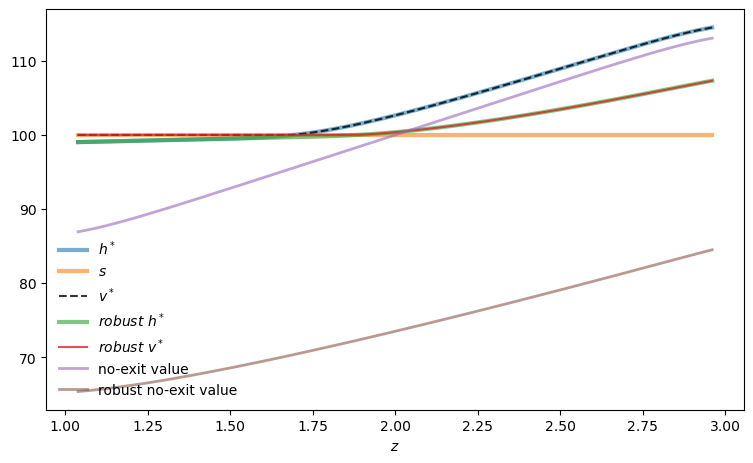

In [10]:
# This is Page 12

# Plots
fig, ax = plt.subplots(figsize=(9, 5.2))

model = create_exit_model()
n, z_vals, Q, β, s = model

v_star, σ_star = vfi(model)
h = z_vals + β * Q @ v_star

v_star_r, σ_star_r = vfi_r(model)
h_r = z_vals - β * np.log(Q @ np.exp(-v_star_r))

w = no_exit_value(model)
w_r = vfi_no_exit_r(model)


ax.plot(z_vals, h, "-", linewidth=3, alpha=0.6, label=r"$h^*$")
ax.plot(z_vals, s * np.ones(n), "-", linewidth=3, alpha=0.6, label=r"$s$")
ax.plot(z_vals, v_star, "k--", linewidth=1.5, alpha=0.8, label=r"$v^*$")

ax.plot(z_vals, h_r, linewidth=3, alpha=0.6, label=r"$robust ~ h^*$")
ax.plot(z_vals, v_star_r, linewidth=1.5, alpha=0.8, label=r"$robust ~ v^*$")

ax.plot(z_vals, w, linewidth=2, alpha=0.6, label="no-exit value")
ax.plot(z_vals, w_r, linewidth=2, alpha=0.6, label="robust no-exit value")

ax.legend(frameon=False)
ax.set_xlabel(r"$z$")

plt.show()